In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import math


#modelo
import numpy as np
import os
import time

from math import sqrt


import pandas as pd
import matplotlib.pyplot as plt

import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

In [2]:
#todo el codigo a compilar 

# def to_var(x, volatile=False):
#     if torch.cuda.is_available():
#         x = x.cuda()
#     return Variable(x, volatile=volatile)


def mkdir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn, mask, sigma = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn, mask, sigma


class Encoder(nn.Module):
    def __init__(self, attn_layers, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        series_list = []
        prior_list = []
        sigma_list = []
        for attn_layer in self.attn_layers:
            x, series, prior, sigma = attn_layer(x, attn_mask=attn_mask)
            series_list.append(series)
            prior_list.append(prior)
            sigma_list.append(sigma)

        if self.norm is not None:
            x = self.norm(x)

        return x, series_list, prior_list, sigma_list


class AnomalyTransformer(nn.Module):
    def __init__(self, win_size, enc_in, c_out, d_model=512, n_heads=8, e_layers=3, d_ff=512,
                 dropout=0.0, activation='gelu', output_attention=True):
        super(AnomalyTransformer, self).__init__()
        self.output_attention = output_attention

        # Encoding
        self.embedding = DataEmbedding(enc_in, d_model, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        AnomalyAttention(win_size, False, attention_dropout=dropout, output_attention=output_attention),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )

        self.projection = nn.Linear(d_model, c_out, bias=True)

    def forward(self, x):
        enc_out = self.embedding(x)
        enc_out, series, prior, sigmas = self.encoder(enc_out)
        enc_out = self.projection(enc_out)

        if self.output_attention:
            return enc_out, series, prior, sigmas
        else:
            return enc_out  # [B, L, D]
        




class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


class AnomalyAttention(nn.Module):
    def __init__(self, win_size, mask_flag=True, scale=None, attention_dropout=0.0, output_attention=False):
        super(AnomalyAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        window_size = win_size
        self.distances = torch.zeros((window_size, window_size)).cuda()
        for i in range(window_size):
            for j in range(window_size):
                self.distances[i][j] = abs(i - j)

    def forward(self, queries, keys, values, sigma, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)
        attn = scale * scores

        sigma = sigma.transpose(1, 2)  # B L H ->  B H L
        window_size = attn.shape[-1]
        sigma = torch.sigmoid(sigma * 5) + 1e-5
        sigma = torch.pow(3, sigma) - 1
        sigma = sigma.unsqueeze(-1).repeat(1, 1, 1, window_size)  # B H L L
        prior = self.distances.unsqueeze(0).unsqueeze(0).repeat(sigma.shape[0], sigma.shape[1], 1, 1).cuda()
        prior = 1.0 / (math.sqrt(2 * math.pi) * sigma) * torch.exp(-prior ** 2 / 2 / (sigma ** 2))

        series = self.dropout(torch.softmax(attn, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", series, values)

        if self.output_attention:
            return (V.contiguous(), series, prior, sigma)
        else:
            return (V.contiguous(), None)


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)
        self.norm = nn.LayerNorm(d_model)
        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model,
                                          d_keys * n_heads)
        self.key_projection = nn.Linear(d_model,
                                        d_keys * n_heads)
        self.value_projection = nn.Linear(d_model,
                                          d_values * n_heads)
        self.sigma_projection = nn.Linear(d_model,
                                          n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)

        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        x = queries
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)
        sigma = self.sigma_projection(x).view(B, L, H)

        out, series, prior, sigma = self.inner_attention(
            queries,
            keys,
            values,
            sigma,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), series, prior, sigma
    



class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.0):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)
    


def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)


def adjust_learning_rate(optimizer, epoch, lr_):
    lr_adjust = {epoch: lr_ * (0.5 ** ((epoch - 1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))



In [3]:
#dataset
class Data_anomSine(Dataset):
    def __init__(self, length=100, amp=1, sf=0.1, f=2, phase=0, anoms=1, magnitud=None, window_size=100,stride=1,anoms_c=3,range_lenght=(10,35), context_anom=True,global_anom=True,normalized=True):
        super().__init__()
        self.list_anomalies=[]
        self.anoms=anoms
        self.range_lenght=range_lenght
        self.anoms_c=anoms_c
        self.magnitud=magnitud
        
        if normalized:
            self.sine_wave = Data_anomSine.sinne_standardized(length, amp, sf, f, phase)
        else:
            self.sine_wave = Data_anomSine.sinne(length, amp, sf, f, phase)

        if context_anom:
            self.add_context_anom()
        if global_anom:
            self.add_global_anom()
        self.array = Data_anomSine.windowed_view(self.sine_wave, window_size,stride=stride)
        self.array = torch.from_numpy(self.array).unsqueeze(-1)


    def __len__(self):
        return self.array.shape[0]

    def __getitem__(self, index):
        return self.array[index]

    @staticmethod
    def sinne(length=100, amp=10, sf=0.1, f=2, phase=0):
        x = torch.arange(0, length * sf, sf)
        y =  amp * torch.sin(x * 2 * torch.pi * (f/5) + phase) *torch.sin(x * 2 * torch.pi * f + phase) #(amp/20)*torch.randn(length) +
        return y

    @staticmethod
    def standardize_signal(signal):
        mean = torch.mean(signal)
        std = torch.std(signal)
        return (signal - mean) / std

    @staticmethod
    def sinne_standardized(length=100, amp=10, sf=0.1, f=2, phase=0):
        signal = Data_anomSine.sinne(length, amp, sf, f, phase)
        return Data_anomSine.standardize_signal(signal)
    
    def add_global_anom(self):
        if self.magnitud is None:
            self.magnitud = self.sine_wave.max().item() - self.sine_wave.min().item()
        index = torch.from_numpy(np.random.choice(np.arange(0, self.sine_wave.size()[0]), size=self.anoms, replace=False))
        self.sine_wave[index] = torch.from_numpy(self.magnitud * np.random.randn(self.anoms)).float() + self.sine_wave[index]
        self.list_anomalies.extend([[i] for i in index.cpu().detach().numpy()])
        

    def add_context_anom(self):
        for i in range(self.anoms_c):
            points_involved = np.random.randint(*self.range_lenght)
            init_index = np.random.randint(0, self.sine_wave.size()[0] - points_involved)
            index = torch.from_numpy(np.arange(init_index, init_index + points_involved))
            self.sine_wave[index] = self.sine_wave[init_index].repeat(points_involved)
            self.list_anomalies.append(list(index.cpu().detach().numpy()))

    @staticmethod
    def windowed_view(x, window_size,stride=1):
        return np.lib.stride_tricks.sliding_window_view(x, (window_size))[::stride].copy()

# Crear una instancia de la clase con los parámetros deseados
#dataset = Data_anomSine(length=1400, sf=0.01, f=0.007, phase=4, anoms=11,stride=1, magnitud=1.5, context_anom=True)


In [4]:
dataset = Data_anomSine(length=4*530, sf=0.01, f=3, phase=4, anoms=2, magnitud=2.5)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


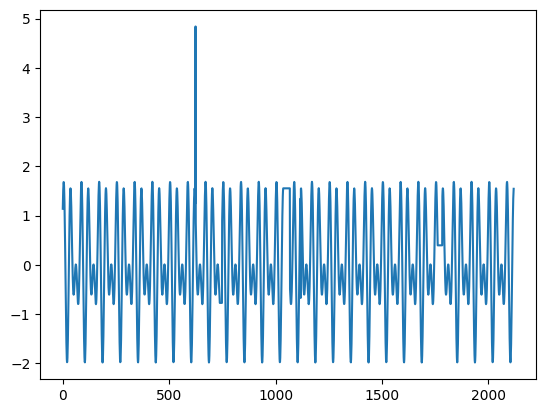

In [5]:
plt.plot(dataset.sine_wave.detach().cpu().numpy())

(16, 100, 1)


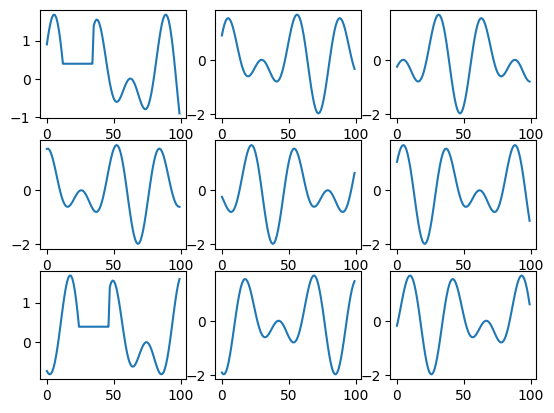

In [6]:
x_aux=next(iter(train_loader))
x_aux=x_aux.cpu().detach().numpy()
print(x_aux.shape)
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.plot(x_aux[i])

In [30]:
#entrenamiento
win_size=100
input_c=1
output_c=1
lr=0.001
num_epochs=130
k=2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

model = AnomalyTransformer(win_size=win_size, enc_in=input_c, c_out=output_c, e_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if torch.cuda.is_available():
    model.cuda()



print("======================TRAIN MODE======================")

time_now = time.time()


train_steps = len(train_loader)
rec_loss_list=[]
min_diss_loss_list=[]
max_diss_loss_list=[]

for epoch in range(num_epochs):
    iter_count = 0
    loss1_list = []

    epoch_time = time.time()
    model.train()
    for i, (input_data) in enumerate(train_loader):

        optimizer.zero_grad()
        iter_count += 1
        input = input_data.float().to(device)

        output, series, prior, _ = model(input)

        # calculate Association discrepancy
        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            series_loss += (torch.mean(my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach())) + torch.mean(
                my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                    win_size)).detach(),
                            series[u])))
            prior_loss += (torch.mean(my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach())) + torch.mean(
                my_kl_loss(series[u].detach(), (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                win_size)))))
        series_loss = series_loss / len(prior)
        prior_loss = prior_loss / len(prior)

        rec_loss = criterion(output, input)
        rec_loss_list.append(rec_loss.item())
        min_diss_loss_list.append(prior_loss.item())
        max_diss_loss_list.append(series_loss.item())

        loss1_list.append((rec_loss - k * series_loss).item())
        loss1 = rec_loss - k * series_loss
        loss2 = rec_loss + k * prior_loss

        if (i + 1) % 100 == 0:
            speed = (time.time() - time_now) / iter_count
            left_time = speed * ((num_epochs - epoch) * train_steps - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()

        # Minimax strategy
        loss1.backward(retain_graph=True)
        loss2.backward()
        optimizer.step()

    print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
    train_loss = np.average(loss1_list)


    print(
        "Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} ".format(
            epoch + 1, train_steps, train_loss))

adjust_learning_rate(optimizer, epoch + 1, lr)


======================TRAIN MODE======================
	speed: 0.0525s/iter; left time: 862.0300s
Epoch: 1 cost time: 6.707378625869751
Epoch: 1, Steps: 127 | Train Loss: -28.2497039 
	speed: 0.0677s/iter; left time: 1102.4707s
Epoch: 2 cost time: 6.762859582901001
Epoch: 2, Steps: 127 | Train Loss: -31.3608154 
	speed: 0.0672s/iter; left time: 1085.6627s
Epoch: 3 cost time: 6.725806713104248
Epoch: 3, Steps: 127 | Train Loss: -31.8016412 
	speed: 0.0670s/iter; left time: 1073.9111s
Epoch: 4 cost time: 6.695964813232422
Epoch: 4, Steps: 127 | Train Loss: -32.0909294 
	speed: 0.0670s/iter; left time: 1065.4604s
Epoch: 5 cost time: 6.687024116516113
Epoch: 5, Steps: 127 | Train Loss: -32.1028992 
	speed: 0.0666s/iter; left time: 1051.0814s
Epoch: 6 cost time: 6.686851263046265
Epoch: 6, Steps: 127 | Train Loss: -32.2093229 
	speed: 0.0676s/iter; left time: 1057.5816s
Epoch: 7 cost time: 6.739582300186157
Epoch: 7, Steps: 127 | Train Loss: -32.2648195 
	speed: 0.0670s/iter; left time: 103

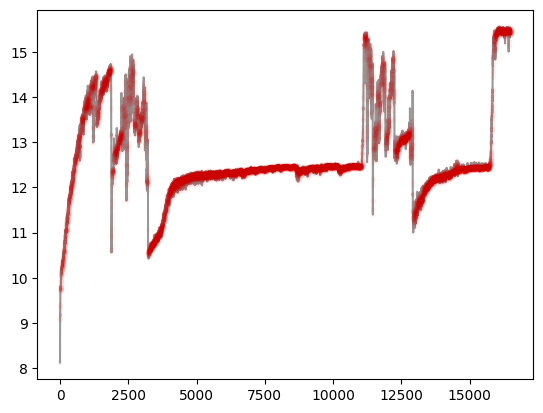

In [ ]:
plt.plot(min_diss_loss_list,alpha=0.4,color="black")
plt.plot(max_diss_loss_list,".",alpha=0.02,color="red")

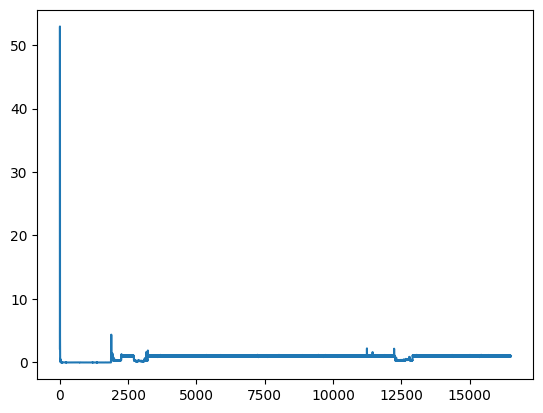

In [ ]:
plt.plot(rec_loss_list)

In [ ]:
data = next(iter(train_loader)).float().to("cuda:0")
dat=data.detach().cpu().numpy()
model.eval()
out, series, prior, sigmas = model(data)

out = out.detach().cpu().numpy()
series = [s.detach().cpu().numpy() for s in series]
prior = [p.detach().cpu().numpy() for p in prior]
sigmas = [sigma.detach().cpu().numpy() for sigma in sigmas]

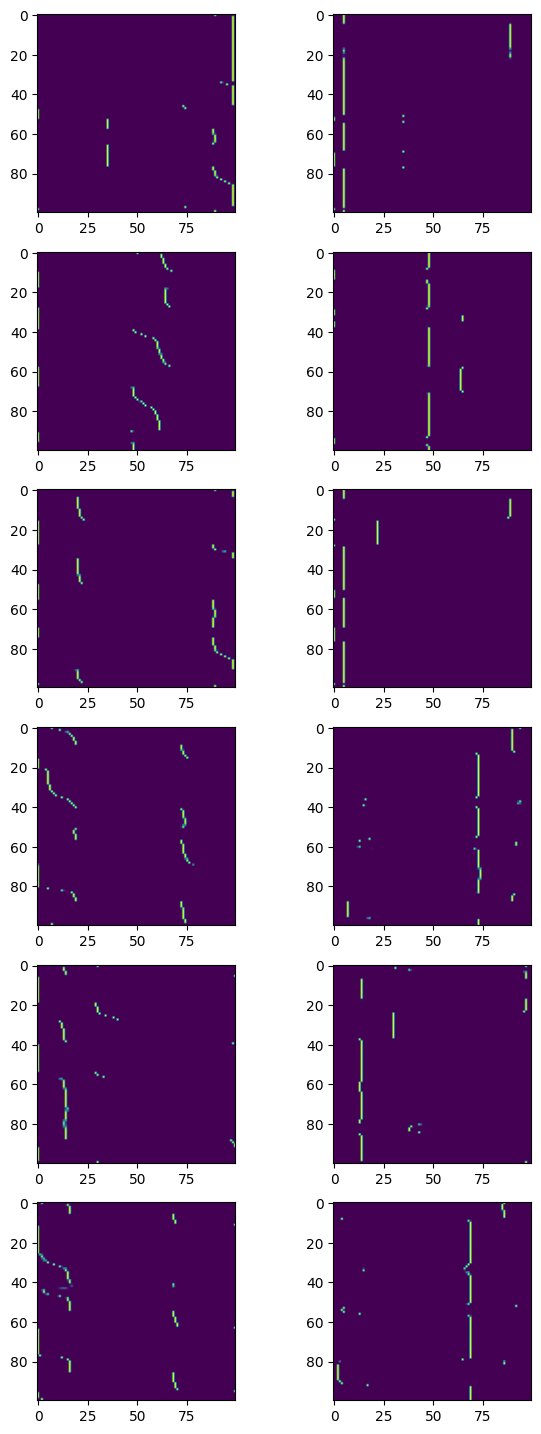

In [ ]:
#plot el asociation
plt.figure(figsize=(7,18))
for i in range(6):
    plt.subplot(6,2,i*2+1)
    plt.imshow(series[0][i,0])
    plt.subplot(6,2,i*2+2)
    plt.imshow(series[0][i,1])

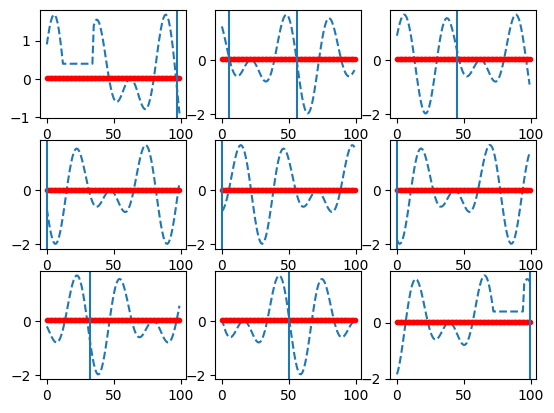

In [ ]:
for j in range(9):
    plt.subplot(3,3,j+1)
    a=series[1][j,0]
    indx=np.unique(np.argwhere(a>np.percentile(a,99))[:,1])
    plt.plot(dat[j],"--")
    plt.plot(out[j],".r")
    for i in indx:
        plt.axvline(i)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

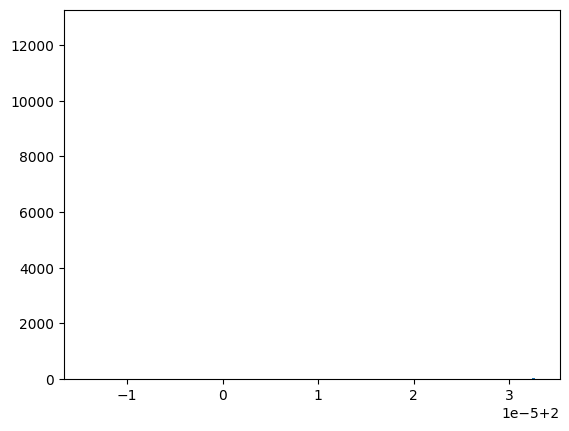

In [ ]:
plt.hist(sigmas[1][:,:,:,0].flatten(),bins=400)

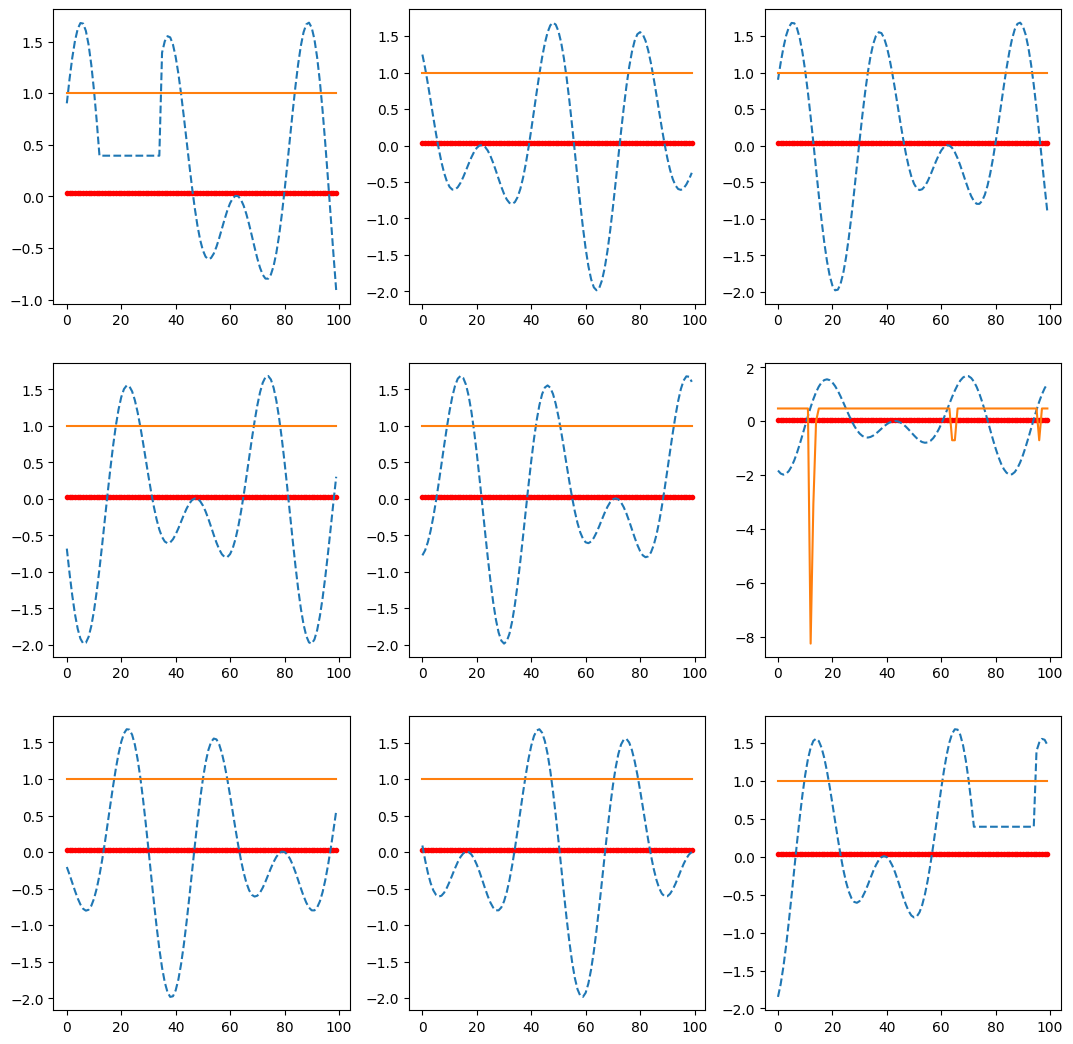

In [ ]:
plt.figure(figsize=(13,13))
stand=lambda X: (X - X.mean())/(X.std())
j=1
for i in range(9):
    plt.subplot(3,3,j)
    j=j+1
    plt.plot(out[i],".r")
    plt.plot(dat[i],"--")
    plt.plot(stand(sigmas[1][i,0,:,0]))
